# Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, sem, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest, proportion_confint, proportion_effectsize
import statsmodels.stats.api as sms
from math import ceil
import datapane as dp
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Business Scenario

A mobile game company wants to test out a new feature in one of their most popular games. The new feature will be moving a checkpoint from level 30 to level 40, the game company would like to know if this change increases game play and increases player retention.

the current retention rate after 1 day is approx. 45% on average and the current retention rate after 7 days is approx. 20% on average. The game change will be considered a success if there is atleast a 2% increase on retention rates for the new feature.
If however retention rates decrease for the new feature then the game change will not be considered.

# Data Information

The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

    * userid: A unique number that identifies each player.
    * version: Whether the player was put in the control group (gate30 - a gate at level 30) or the group with the moved gate (gate40 - a gate at level 40).
    * sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
    * retention_1: Did the player come back and play 1 day after installing?
    * retention_7: Did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either.

#  Hypothesis Formulation

As we dont know if the new game feature will perform better or worse than the current game feature we will opt for a two tailed test:

    Ho: P_gate30 = P_gate40
    Ha: P_gate30 != P_gate40
    
We will set the confidence level to 95% with an alpha value of 5%, if the probability of observing results as extreme or more (p value) is less than alpha then we can reject the null hypotesis.

Formerly the p value is the probability of observing the result given that the null hypothesis is true.

# Calculate Sample size (Power Analysis)

Power analysis is usually conducted before the data collection and is to determine the smallest sample size that is suitable to detect the effect of a given test at a desired significance level. But why not use all the data we can get our hands on? Because collecting large amounts of data can often be costly, this way we keep costs down whilst still being able to detect an effect if there is one.

As we are simulating a business scenario with data already collected we will perform this step but as stated this is usually performed pre data collection.
    
In order to calculate the required sample size we need to have three bits of information; effect size, statistical power and alpha.
    
***effect size:*** 
The effect that you wish to be able to detect from the test if there is one, in our case the 2% increase in retention rates.
    
***statistical power:*** 
the probability of correctly rejecting the null hypothesis (true positive), commonly 0.8 or 80%
    
***alpha (significance level):***
The boundary for specifiying a statistically siginificant finding when interpreting the p value, commonly 0.05 or 5%.
p < alpha = reject null, accept alternative. p > alpha = fail to reject null, p == alpha = marginal
    
As the company has already stated they would like to detect a 2% increase in retention rates for the new game feature to be a success, this will be our effect size. We will use the common values for statistical power (80%) and alpha (5%).

## retention after 1 day

In [2]:
## calculate effect size from current expected rates
effect_size = proportion_effectsize(0.45, 0.47) 
# calaculate sample size
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05,
    ratio=1
)
required_n = ceil(required_n)   # round up to integer
print(f'Required sample size: {required_n}')

Required sample size: 9747


## retention after 7 days

In [3]:
## calculate effect size from current expected rates
effect_size = proportion_effectsize(0.2, 0.22) 
# calaculate sample size
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
)
required_n = ceil(required_n)   # round up to integer
print(f'Required sample size: {required_n}')

Required sample size: 6508


We need atleast 9747 samples of each version to detect the 2% uplift in retention rates after 1 day and 6508 samples of each version to detect the 2% uplift in retention rates after 7 days.

# Load & Split Data

Let us load the data for inspection and any neccessary cleaning.

In [4]:
data = pd.read_csv('cookie_cats.csv')
# split data into a/b versions
gate_30 = data[data['version']=='gate_30']
gate_40 = data[data['version']=='gate_40']

# Data Cleaning

In [5]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


As can be seen we have 5 variables; userid - the game id of the user, version - whether the user played the game with the old feature (gate_30) or the new feature (gate_40), sum_gamerounds - the number of games the user played over the 14 day period that the data were collected, retention_1 - whether the user played the game 1 day after installation, retention_7 - whether the user played the game 7 days after install

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [7]:
# gate information
print('Gate 30 Info:')
gate_30.info()
print('\nGate 40 Info:')
gate_40.info()

Gate 30 Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 44700 entries, 0 to 90186
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          44700 non-null  int64 
 1   version         44700 non-null  object
 2   sum_gamerounds  44700 non-null  int64 
 3   retention_1     44700 non-null  bool  
 4   retention_7     44700 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.4+ MB

Gate 40 Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 45489 entries, 2 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          45489 non-null  int64 
 1   version         45489 non-null  object
 2   sum_gamerounds  45489 non-null  int64 
 3   retention_1     45489 non-null  bool  
 4   retention_7     45489 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.5+ MB


A quick inspection shows that the variables all have the same observation counts, are all non-null and all have the correct data types.

In [8]:
# data descriptions
print(f'Gate 30:\n{gate_30.describe()}\n')
print(f'Gate 40:\n{gate_40.describe()}\n')

Gate 30:
             userid  sum_gamerounds
count  4.470000e+04    44700.000000
mean   4.987564e+06       52.456264
std    2.881026e+06      256.716423
min    1.160000e+02        0.000000
25%    2.505469e+06        5.000000
50%    4.983631e+06       17.000000
75%    7.481497e+06       50.000000
max    9.999710e+06    49854.000000

Gate 40:
             userid  sum_gamerounds
count  4.548900e+04    45489.000000
mean   5.009073e+06       51.298776
std    2.885496e+06      103.294416
min    3.770000e+02        0.000000
25%    2.517171e+06        5.000000
50%    5.007329e+06       16.000000
75%    7.510762e+06       52.000000
max    9.999861e+06     2640.000000



from data descriptions we can see that gate 30 has an extreme number of total games played in the first 14 days of install by a single user, we will look into this. Distributions for both control and test groups seem to be right skewed which is to be expected with large max counts.

In [9]:
gate_30[gate_30['sum_gamerounds']>2000]

,userid,version,sum_gamerounds,retention_1,retention_7
7912,871500,gate_30,2961,True,True
43671,4832608,gate_30,2438,True,True
46344,5133952,gate_30,2251,True,True
57702,6390605,gate_30,49854,False,True
87007,9640085,gate_30,2156,True,True


as there is only one extreme value in the data and we dont know how the data were collected, we are unable to assume if it is likely to be an error or just an addicted player. As we have highly skewed data we can perform non parametric tests which have no assumptions on the underlying distribution of the data.

In [10]:
# check for duplicates
dups = data.duplicated().sum()
print(f'number of duplicated observations: {dups}')

number of duplicated observations: 0


In [11]:
# check for userid duplicates
user_dups = data['userid'].duplicated().sum()
print(f'number of duplicated users: {user_dups}')

number of duplicated users: 0


Now that the data is prepared we can sample the required amount

    *** NOTE... GENERALLY WE WOULD NOT NEED TO DO THIS AS THE REQUIRED SAMPLE SIZE WOULD BE COLLECTED
        PRIOR TO PERFORMING ANALYSES. 
        AS WE ARE SIMULATING A BUSINESS SCENARIO WITH ALREADY COLLECTED DATA WE WILL PERFORM THIS STEP.

# Sample Data

In [12]:
# sample the required size data
control_sample = gate_30.sample(n=9747, random_state=42)
treatment_sample = gate_40.sample(n=9747, random_state=42)
ab_test = pd.concat([control_sample, treatment_sample], axis=0).reset_index(drop=True)
ab_test

,userid,version,sum_gamerounds,retention_1,retention_7
0,6531033,gate_30,35,False,False
1,8003009,gate_30,4,False,False
2,5566807,gate_30,23,True,False
3,64235,gate_30,1,False,False
4,6210551,gate_30,7,False,False
...,...,...,...,...,...
19489,2884820,gate_40,20,True,False
19490,9669376,gate_40,23,False,False
19491,8458512,gate_40,198,True,True
19492,8594704,gate_40,10,False,False


In [13]:
# check we have sampled the required size
ab_test['version'].value_counts()

gate_30    9747
gate_40    9747
Name: version, dtype: int64

Now that we have the required sample sizes we can now perform data analysis.

# Data Analysis

First lets take a look at sum_gamerounds.

## Sum Game Rounds

In [14]:
ab_test['sum_gamerounds'].describe()

count    19494.000000
mean        51.699959
std         99.712055
min          0.000000
25%          5.000000
50%         16.000000
75%         52.000000
max       1816.000000
Name: sum_gamerounds, dtype: float64

A quick description shows the data to be right skewed with the mean value higher than the median value

Lets take a look at total number of game rounds played per version

In [15]:
# total number of games played per version
tot_num_games = ab_test.groupby('version').sum()['sum_gamerounds']
tot_num_games

version
gate_30    495165
gate_40    512674
Name: sum_gamerounds, dtype: int64

In [16]:
# gate 40 difference in games played
games_diff = tot_num_games['gate_40'] - tot_num_games['gate_30']
print(f'gate 40 has seen a {games_diff} increase in game rounds played')

gate 40 has seen a 17509 increase in game rounds played


In [17]:
# percentage increase in game rounds for gate 40
pct_inc = np.round((tot_num_games['gate_40']-tot_num_games['gate_30'])/tot_num_games['gate_30']*100,2)
print(f'gate 40 percentage increase for total games played: {pct_inc}%')

gate 40 percentage increase for total games played: 3.54%


As we can see the new feature version (gate 40) has seen an increase in number of game rounds played of 17509, thats a percentage increse of 3.54%

In [18]:
# game counts for version and retention type
v_g30 = ab_test[ab_test['version']=='gate_30']
v_g40 = ab_test[ab_test['version']=='gate_40']

## combined versions
# retained for full test period
full_ret = ab_test.loc[(ab_test['retention_1']==True)&(ab_test['retention_7']==True)]['sum_gamerounds'].sum()
# retained after 1 day but not 7
ret1_only = ab_test.loc[(ab_test['retention_1']==True)&(ab_test['retention_7']==False)]['sum_gamerounds'].sum()
# retained after 7 days but not 1
ret7_only = ab_test.loc[(ab_test['retention_1']==False)&(ab_test['retention_7']==True)]['sum_gamerounds'].sum()
# no retention from 1 day onwards
no_ret = ab_test.loc[(ab_test['retention_1']==False)&(ab_test['retention_7']==False)]['sum_gamerounds'].sum()

##version gate_30
# retained for full test period
vg30_full_ret = v_g30.loc[(v_g30['retention_1']==True)&(v_g30['retention_7']==True)]['sum_gamerounds'].sum()
# retained after 1 day but not 7
vg30_ret1_only = v_g30.loc[(v_g30['retention_1']==True)&(v_g30['retention_7']==False)]['sum_gamerounds'].sum()
# retained after 7 days but not 1
vg30_ret7_only = v_g30.loc[(v_g30['retention_1']==False)&(v_g30['retention_7']==True)]['sum_gamerounds'].sum()
# no retention from 1 day onwards
vg30_no_ret = v_g30.loc[(v_g30['retention_1']==False)&(v_g30['retention_7']==False)]['sum_gamerounds'].sum()

##version gate_40
# retained for full test period
vg40_full_ret = v_g40.loc[(v_g40['retention_1']==True)&(v_g40['retention_7']==True)]['sum_gamerounds'].sum()
# retained after 1 day but not 7
vg40_ret1_only = v_g40.loc[(v_g40['retention_1']==True)&(v_g40['retention_7']==False)]['sum_gamerounds'].sum()
# retained after 7 days but not 1
vg40_ret7_only = v_g40.loc[(v_g40['retention_1']==False)&(v_g40['retention_7']==True)]['sum_gamerounds'].sum()
# no retention from 1 day onwards
vg40_no_ret = v_g40.loc[(v_g40['retention_1']==False)&(v_g40['retention_7']==False)]['sum_gamerounds'].sum()

# create dataframe
games_plyd_df = pd.DataFrame(
    {
        'Version':[
            'Gate 30',
            'Gate 40'
        ],
        'Full Retention':[
        vg30_full_ret,
        vg40_full_ret
        ],
        'Retention 1':[
            vg30_ret1_only,
            vg40_ret1_only 
        ],
        'Retention 7':[
            vg30_ret7_only,
            vg40_ret7_only
        ],
        'No Retention':[
            vg30_no_ret,
            vg40_no_ret
        ]
    }
)

comb_games_plyd_df = pd.DataFrame(
    {
        'Version': 'Combined',
        'Full Retention': full_ret,
        'Retention 1': ret1_only,
        'Retention 7': ret7_only,
        'No Retention': no_ret
    },
    index=range(0,1)
)
print(f'Versions Gate 30 & Gate 40:\n{games_plyd_df}\n\nCombined Version:\n{comb_games_plyd_df}')

Versions Gate 30 & Gate 40:
   Version  Full Retention  Retention 1  Retention 7  No Retention
0  Gate 30          265906       143986        28469         56804
1  Gate 40          272489       151447        27612         61126

Combined Version:
    Version  Full Retention  Retention 1  Retention 7  No Retention
0  Combined          538395       295433        56081        117930


In [19]:
idx_array = [['Gate 30','Gate 40'],
             ['Full Retention','Retention 1','Retention 7','No Retention']]
index = pd.MultiIndex.from_product(idx_array, names=['Version', 'Retention_type'])
games_plyd_mi = pd.Series([vg30_full_ret,vg30_ret1_only,vg30_ret7_only,vg30_no_ret,vg40_full_ret,vg40_ret1_only,vg40_ret7_only,vg40_no_ret], index=index, name='games_played')
games_plyd_pct = np.round(games_plyd_mi / games_plyd_mi.groupby('Version').transform('sum')*100,1)
games_plyd_pct

Version  Retention_type
Gate 30  Full Retention    53.7
         Retention 1       29.1
         Retention 7        5.7
         No Retention      11.5
Gate 40  Full Retention    53.2
         Retention 1       29.5
         Retention 7        5.4
         No Retention      11.9
Name: games_played, dtype: float64

Breaking down the number of games played for retention status we can see that the majority of games played were by users who were retained for both 1 day a 7 day retention flags.

In [20]:
avg_game_play = ab_test.groupby('version')['sum_gamerounds']
std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the mean
se_p = lambda x: sem(x, ddof=0)            # Std. error of the mean (std / sqrt(n))
avg_game_play = avg_game_play.agg([np.mean, np.median, std_p, se_p, np.var])
avg_game_play.columns = ['Average_game_play', 'Median_game_play', 'std_deviation', 'std_error', 'variance']
avg_game_play

,Average_game_play,Median_game_play,std_deviation,std_error,variance
version,,,,,
gate_30,50.801785,16.0,98.887957,1.001631,9779.831423
gate_40,52.598133,17.0,100.516298,1.018125,10104.562783


We can see that the average number of games played is slightly higher for the gate40 version whilst also being more spread about the mean.

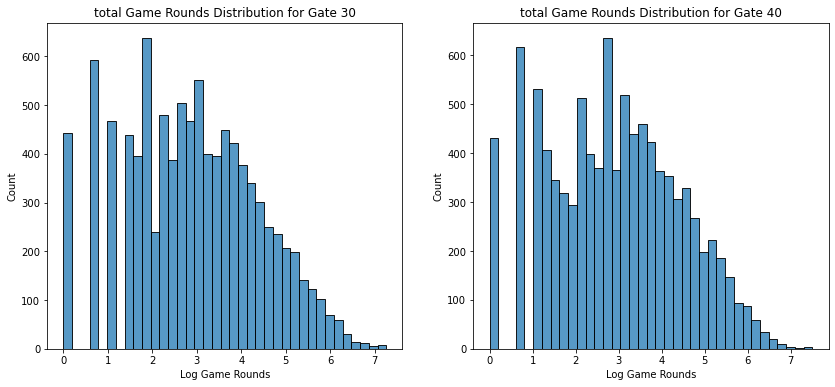

In [21]:
# total game rounds distribution per version
tot_game_rounds_dist, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
g30 = ab_test[ab_test['version']=='gate_30']
g40 = ab_test[ab_test['version']=='gate_40']
sns.histplot(data=g30, x=np.log(g30['sum_gamerounds']+1), ax=ax1)
ax1.set_title('total Game Rounds Distribution for Gate 30')
ax1.set_xlabel('Log Game Rounds')
ax1.set_ylabel('Count')

sns.histplot(data=g40, x=np.log(g40['sum_gamerounds']+1), ax=ax2)
ax2.set_title('total Game Rounds Distribution for Gate 40')
ax2.set_xlabel('Log Game Rounds')
ax2.set_ylabel('Count')

plt.show()

The distribution of sum_gamerounds for each version does not appear to be normally distributed, as this is an assumption for parametric tests will have to perform a non-parametric test (mann-whitney u test or bootstrap permutation test).

## Retention 1

Lets check the number of players we did retain after 1 day of installation for each version.

In [22]:
# count user retention
ret_num_1 = ab_test.groupby('version').sum()['retention_1']
ret_num_1

version
gate_30    4350
gate_40    4373
Name: retention_1, dtype: int64

In [23]:
# user retention version difference
ret_diff = ret_num_1['gate_40']-ret_num_1['gate_30']
print(f'gate 40 showed an increase in retention of {ret_diff} users')

gate 40 showed an increase in retention of 23 users


In [24]:
# percentage increase for gate 40 retention
pct_diff_inc = np.round((ret_num_1['gate_40']-ret_num_1['gate_30'])/ret_num_1['gate_30']*100, 2)
print(f'gate 40 showed a percentage increase of {pct_diff_inc}% for user retention after 1 day')

gate 40 showed a percentage increase of 0.53% for user retention after 1 day


From the analysis above we can see that the new feature (gate 40) showed an increase of 23 users retained after 1 day of installation, this amounts to a 0.53 percentage increase.

Lets now take a look at retention rates after 1 day.

In [25]:
# retention rates retention_1 analysis
retention_1_rates = ab_test.groupby('version')['retention_1']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

retention_1_rates = retention_1_rates.agg([np.mean, std_p, se_p])
retention_1_rates.columns = ['retention_rate', 'std_deviation', 'std_error']
retention_1_rates = retention_1_rates*100
retention_1_rates

,retention_rate,std_deviation,std_error
version,,,
gate_30,44.629117,49.710699,0.503517
gate_40,44.865087,49.735628,0.503770


We can see that the difference in retention rate proportions is minimal as is for standard deviation and standard error, with gate 40 having a slight increase over gate 30. From here it seems that there is no difference between retention rates after 1 day for each version but by performing a hypothesis test we will determine if the difference is statistically significant or not.

In [26]:
# total games played retention 1
total_games = ab_test.groupby(['version','retention_1']).agg({'sum_gamerounds':'sum'})
total_games

sum_gamerounds
version retention_1                
gate_30 False                 85273
        True                 409892
gate_40 False                 88738
        True                 423936

In [27]:
# gate 40 percentage increase of games played by players that returned to play after one day
# ..% more games played by returning players that played the new game feature
g30_sgr = total_games.loc[(total_games.index.get_level_values('version') == 'gate_30')&(total_games.index.get_level_values('retention_1') == True)].values
g40_sgr = total_games.loc[(total_games.index.get_level_values('version') == 'gate_40')&(total_games.index.get_level_values('retention_1') == True)].values
pct_inc = float((g40_sgr-g30_sgr)/g30_sgr*100)
print(f'gate 40 percentage of total games played increase for returning users: {np.round(pct_inc,2)}%')

gate 40 percentage of total games played increase for returning users: 3.43%


Of the total number of games played by users that returned after 1 day of installation for each version, the new version (gate 40) has seen a 3.43% increase in the number of games played. Which can be expected as the new version had more games played to begin with.

In [28]:
# percentage of games played per version
ret1_game_ply_pct = ab_test.groupby(['version','retention_1'])['sum_gamerounds'].sum()/ ab_test.groupby('version').sum()['sum_gamerounds']*100
ret1_game_ply_pct

version  retention_1
gate_30  False          17.221128
         True           82.778872
gate_40  False          17.308855
         True           82.691145
Name: sum_gamerounds, dtype: float64

In [29]:
ret1_game_ply_pct.index.get_level_values('retention_1')

Index([False, True, False, True], dtype='object', name='retention_1')

We can see that game play percentages for each version are also very similar.

## Retention 7

Again let us check the number of users we did retain after 7 days of intallation.

In [30]:
# number of retained users after 7 days
ret_num_7 = ab_test.groupby('version').sum()['retention_7']
ret_num_7

version
gate_30    1836
gate_40    1828
Name: retention_7, dtype: int64

In [31]:
# gate 30 retained user difference
ret_diff_7 = ret_num_7['gate_30']-ret_num_7['gate_40']
print(f'gate 30 shows an increase of {ret_diff_7} retained users')

gate 30 shows an increase of 8 retained users


In [32]:
# gate 30 retained user percentage increase
ret7_pct_inc = np.round((ret_num_7['gate_30']-ret_num_7['gate_40'])/ret_num_7['gate_40']*100, 2)
print(f"gate 30's retained users equates to a {ret7_pct_inc} percentage increase")

gate 30's retained users equates to a 0.44 percentage increase


From the number of retained users for each version after 7 days of installation we can see that the current version (gate 30) has an increase of 8 retained users which is an increase of 0.44% over the new version (gate 40).

In [33]:
# retention rates retention_7
retention_7_rates = ab_test.groupby('version')['retention_7']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

retention_7_rates = retention_7_rates.agg([np.mean, std_p, se_p])
retention_7_rates.columns = ['retention_rate', 'std_deviation', 'std_error']
retention_7_rates = retention_7_rates*100
retention_7_rates

,retention_rate,std_deviation,std_error
version,,,
gate_30,18.836565,39.100388,0.396046
gate_40,18.754489,39.034831,0.395382


We can see that retention rates have decreased dramatically with only approx. 19% of players returning to play after 7 days of install. It can be seen that gate 30 now has an increase over gate 40 but again the difference between versions is minimal, we will test to see if this difference is statistically significant or not.

In [34]:
# total games played retention 7
total_games = ab_test.groupby(['version','retention_7']).agg({'sum_gamerounds':'sum'})
total_games

sum_gamerounds
version retention_7                
gate_30 False                200790
        True                 294375
gate_40 False                212573
        True                 300101

In [35]:
# gate 40 percentage increase of games played by players that returned to play after one day
# ..% more games played by returning players that played the new game feature
g30_sgr = total_games.loc[(total_games.index.get_level_values('version') == 'gate_30')&(total_games.index.get_level_values('retention_7') == True)].values
g40_sgr = total_games.loc[(total_games.index.get_level_values('version') == 'gate_40')&(total_games.index.get_level_values('retention_7') == True)].values
pct_inc = float((g40_sgr-g30_sgr)/g30_sgr*100)
print(f'gate 40 percentage of total games played increase for returning users: {np.round(pct_inc,2)}%')

gate 40 percentage of total games played increase for returning users: 1.95%


Of the total number of games played by users that returned after 7 days of installation for each version, the new version (gate 40) has seen a 1.95% increase in the number of games played. Again this can be expected as the new version had more game rounds played.

We can check the percentage of games played by retained users after 7 days.

In [36]:
# percentage of games played per version
ret7_game_play_pct = ab_test.groupby(['version','retention_7'])['sum_gamerounds'].sum()/ ab_test.groupby('version').sum()['sum_gamerounds']*100
ret7_game_play_pct

version  retention_7
gate_30  False          40.550120
         True           59.449880
gate_40  False          41.463581
         True           58.536419
Name: sum_gamerounds, dtype: float64

In [89]:
# 95% permutation confidence interval for difference in game play proportions for retention_7 versions
act_diff = game_play_pct['gate_30'][1]-game_play_pct['gate_40'][1]
n_iter=10000
pct_diffs = []
for _ in range(n_iter):
    g30 = ab_test.sample(n=9747) # sample size g30
    g40_idx = [x for x in ab_test.index if x not in g30.index] # get non index of g30
    g40 = ab_test.iloc[g40_idx, :] # sample sizeg40
    # calculate percentages of games played for retained users
    g30_pct = g30.groupby('retention_7')['sum_gamerounds'].sum()/ np.sum(g30['sum_gamerounds'])*100
    g40_pct = g40.groupby('retention_7')['sum_gamerounds'].sum()/ np.sum(g40['sum_gamerounds'])*100
    g30_pct = g30_pct[1]
    g40_pct = g40_pct[1]
    pct_diff = g30_pct-g40_pct # get difference
    pct_diffs.append(pct_diff)
    
lower_bound, upper_bound = np.percentile(pct_diffs, [2.5, 97.5])
print(f'actual difference between percentages of games played for retained users per version: {np.round(act_diff,2)}')
print(f'95% CI for difference between percentages of games played for retained users per version: ({lower_bound}, {upper_bound})')

actual difference between percentages of games played for retained users per version: 0.91
95% CI for difference between percentages of games played for retained users per version: (-2.6984238283847906, 2.700463748461197)


We can see that there is a 0.91% increase in games played for retained users for gate 30 version, after computing a permuted 95% confidence interval we can see that the interval contans 0 which means this observation is likely due to chance variation within the data.

Lets now visually take a look at retention rates with a bar chart.

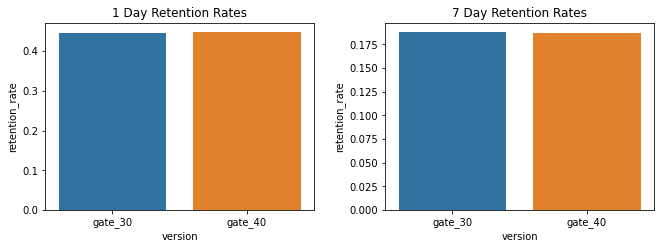

In [19]:
# visualise rates
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
plt.tight_layout(pad=4)
sns.barplot(data=retention_1_rates, x=retention_1_rates.index, y='retention_rate', ax=ax1)
ax1.set_title('1 Day Retention Rates')
sns.barplot(data=retention_7_rates, x= retention_7_rates.index, y='retention_rate', ax=ax2)
ax2.set_title('7 Day Retention Rates')
plt.show()

We can see from the retention rates of each version for each retention flag that there is not much difference between the two versions, Gate 40 performs slightly better for retention_1 and gate 30 performs slightly better for retention_7. We can test to see whether the difference between the two versions for each flag is statistically significant.

# Hypothesis Testing

Firstly we will split the data into control (gate 30) and treatment (gate 40) sets.

In [5]:
control = ab_test[ab_test['version']=='gate_30']
treatment = ab_test[ab_test['version']=='gate_40']

## sum_gamerounds

Now that we have our control and treatment sets we can start testing. For our first test we will test to see if the difference in number of games played for each version is statistically significant, we found that the version with the new game feature (gate 40) on average had a higher number of games played.

As we are uncertain of knowing whether the new game feature would perform better or worse than the original feature we will perform a two sided hyptothesis test. Our null hypothesis will be that there is no difference in average game play between game versions and our alternative hypothesis will be that there is a difference in average game play between game versions. The test will be conducted with 95% confidence and a significance level of 5%, this means that we have a 95% chance of detecting an effect if there is one and if the p-value (probability of observing a difference between game play as great as the difference we observed) is less than 5% then we can reject the null hypothesis and state that there is a statistically significant difference between version game play (the version with gate 40 on average does have a higher number of games played).

We will perform a non-parametric test as the data is non normally distributed.

In [16]:
# two sided non parametric hypothesis test for difference in means
# h0 = 0 (there is no difference in means)
# ha != 0 (there is a difference in means)
# significance level = 0.05

g30_sgr = ab_test[ab_test['version']=='gate_30']['sum_gamerounds']
g40_sgr = ab_test[ab_test['version']=='gate_40']['sum_gamerounds']
_, pval = mannwhitneyu(g30_sgr, g40_sgr, alternative='two-sided')
if pval <= 0.05:
    print(f'Two sided hypothesis test for difference in means for sum_gamerounds:\nDifference in means not due to chance, reject the null hypotheses\nP value: {pval}')
else:
    print(f'Two sided hypothesis test for difference in means for sum_gamerounds:\nDifference in means likely due to chance, fail to reject the null hypotheses\nP value: {pval}')

Two sided hypothesis test for difference in means for sum_gamerounds:
Difference in means likely due to chance, fail to reject the null hypotheses
P value: 0.39649082460452945


As we can see from our test results we obtained a p-value of approx. 0.40 or 40%, this means that on average we can expect to see a difference as large as the one we observed 40% of the time. This is way above our significanace level of 5% and therefore we fail to reject the null hypothesis and state that there is statistically no difference between the game play of both versions.

In [6]:
# 95% confidence interval for difference of means for sum_gamerounds
gate30_mean = avg_game_play['Average_game_play']['gate_30']
gate40_mean = avg_game_play['Average_game_play']['gate_40']
gate30_std = avg_game_play['std_deviation']['gate_30']
gate40_std = avg_game_play['std_deviation']['gate_40']
gate30_var = avg_game_play['variance']['gate_30']
gate40_var = avg_game_play['variance']['gate_40']
gate30_n = ab_test[ab_test['version']=='gate_30'].shape[0]
gate40_n = ab_test[ab_test['version']=='gate_40'].shape[0]
# calculate degrees of freedom
dof = gate40_n + gate30_n - 2 # = 19492
# two tailed t value at 95% confidence
t_val = 1.96 # high sample size means t distribution is the sames as z distribution
# pooled standard deviation
sp = np.sqrt(((gate40_n-1)*gate40_var+(gate30_n-1)*gate30_var)/dof)
# margin of error
moe = t_val*sp*np.sqrt((1/gate40_n)+(1/gate30_n))
# confidence interval
conf_int = ((gate40_mean-gate30_mean)-moe,(gate40_mean-gate30_mean)+moe)
print(f'95% confidence interval for difference in means for sum_gamerounds: {conf_int}')

95% confidence interval for difference in means for sum_gamerounds: (-1.003128547029331, 4.595823735292381)


After computing a 95% confidence interval for the difference in means for gate 30 and gate40 of sum_gamerounds, we can see that the null value of 0 is within the interval meaning that a value of 0 is well within chance variation of the data.

## retention_1

Next we will test the difference in proportions for the retention_1 variable and see if the difference is statistically significant, initially we found that the game version with the new feature (gate40) had a slighty higher retention rate after 1 day.

Again we will perform a two sided test with a 95% confidence level and significance level of 5%, our null hypothesis will be that there is no difference between proportions and our alternative hypothesis is that there is a difference between proportions.

In [23]:
# sampled data... using statsmodels package
zstat, pval = proportions_ztest(count=[control['retention_1'].sum(),treatment['retention_1'].sum()], nobs=[len(control),len(treatment)], value=0, alternative='two-sided')
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint([control['retention_1'].sum(),treatment['retention_1'].sum()], nobs=[len(control),len(treatment)], alpha=0.05)
print(f'z statistic: {zstat}\nP value: {pval}\nControl CI: ({lower_con},{upper_con})\nTreatment CI: ({lower_treat},{upper_treat})')

z statistic: -0.33129689661546446
P value: 0.740420235220633
Control CI: (0.43642240896668855,0.4561599240588578)
Treatment CI: (0.4387771604754418,0.4585245733913891)


As we obtained a p value of 0.74 meaning we will see a difference as great or more than our observed difference 74% of the time as this is well above our 5% significance level threshold we fail to reject the null hypothesis and state that there is no difference between version proportions.

In [18]:
# 95% confidence interval for difference of proportions for retention_1
critical_value = 1.96
gate30_prop = control['retention_1'].mean()
gate40_prop = treatment['retention_1'].mean()
gate30_n = len(control)
gate40_n = len(treatment)
# standard error
se = np.sqrt((gate30_prop * (1-gate30_prop))/gate30_n + (gate40_prop * (1-gate40_prop))/gate40_n)
# margin of error
me = critical_value * se
print(f'95% confidence interval for difference in retention_1 proportions: {((gate30_prop-gate40_prop)-me, (gate30_prop-gate40_prop)+me)}')

95% confidence interval for difference in retention_1 proportions: (-0.016319987557399836, 0.011600586716115309)


We can also conclude that there is no difference between proportions by computing a 95% confidence interval, and as can be seen the null value 0 is within the bounds of interval. This means that if we repeatedly took new samples and calulated the difference between versions, 95% of the time the difference will fall inside the confidence interval bounds and as 0 is within the bounds we can also observe differences of 0.

## retention_7

Finally lets test the difference in proportions for retention_7.

In [24]:
# sampled data... using statsmodels package
zstat, pval = proportions_ztest(count=[control['retention_7'].sum(),treatment['retention_7'].sum()], nobs=[len(control),len(treatment)], value=0, alternative='two-sided')
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint([control['retention_7'].sum(),treatment['retention_7'].sum()], nobs=[len(control),len(treatment)], alpha=0.05)
print(f'z statistic: {zstat}\nP value: {pval}\nControl CI: ({lower_con},{upper_con})\nTreatment CI: ({lower_treat},{upper_treat})')

z statistic: 0.1466635787105074
P value: 0.8833975676439857
Control CI: (0.18060329289656618,0.196128009042492)
Treatment CI: (0.17979554215753307,0.1952942290541218)


Again as the P value suggests the probability of observing a difference in proportions as greater than or equal to the observed difference between control and treatment, with the p value (approx. 0.88 or 88%) being extremely high, way above our 0.05 or 5% threshold, we fail to reject the null hypothesis and state that there is no difference between control (original checkpoint(gate 30)) and treatment (new checkpoint (gate 40)) retention rates.

In [19]:
# 95% confidence interval for difference of proportions for retention_7
critical_value = 1.96
con_prop = control['retention_7'].mean() # gate 30
treat_prop = treatment['retention_7'].mean() # gate 40
con_n = len(control) # gate 30
treat_n = len(treatment) # gate 40
# standard error
se = np.sqrt((con_prop * (1-con_prop))/con_n + (treat_prop * (1-treat_prop))/treat_n)
# margin of error
me = critical_value * se
print(f'95% confidence interval for difference in retention_7 proportions: {((con_prop-treat_prop)-me, (con_prop-treat_prop)+me)}')

95% confidence interval for difference in retention_7 proportions: (-0.010147869381593835, 0.011789400108997141)


This can also be re-iterated with a 95% confidence intereval for the difference in proportions as the interval contains 0. Also looking at the treatment confidence interval it does not contain the 2% retention rate increase of 22%.

# Conclusion

We found in the data that the average games played for the treatment (version gate 40) of sum_gamerounds was higher than control (version gate 30), this was found to be likely due to chance with a mann-whitney u test obtaining a p value of 0.3964. For retention rates after 1 day (retention_1) we found again the treatment proportion was higher than that of control but this also was likely due to chance occurence using a z test obtaining a p value of 0.7404. Finally looking at retention rates after 7 days (retention_7) we found that the control proportion was higher than that of treatment but also again this was likely a chance occurence using a z test obtaining a p value of 0.8833.

Comupting treatment confidence intervals for both retention rates we found that neither retention rates saw an uplift of 2%.

We can conclude that we do not have enough evidence to support our alternative hypothesis of there being a difference in version retention rates and that any observed differences are due to chance. Neither treatment retention rates showed a decrease but also showed no signs of a 2% uplift.

# Report

In [49]:
# ab test report
ret_1_chart = px.bar(
    retention_1_rates.reset_index(), 
    x='version', 
    y='retention_rate',
    title='1 Day Retention Rate per Version',
    color_discrete_sequence=['#1616A7'],
    labels={'version':'Version', 'retention_rate':'Retention Rate'},
    template='simple_white',
    text_auto=True
)
ret_1_chart.update_yaxes(tickprefix='%', showgrid=True)
ret_7_chart = px.bar(
    retention_7_rates, 
    x=retention_7_rates.index, 
    y='retention_rate',
    title='7 Day Retention Rate per Version',
    color_discrete_sequence=['#1616A7'],
    labels={'version':'Version', 'retention_rate':'Retention Rate'},
    template='simple_white',
    text_auto=True
)
ret_7_chart.update_yaxes(tickprefix='%', showgrid=True)
# total games distribution plots
# gate 30
g30_dist = px.histogram(
    g30,
    x=np.log(g30['sum_gamerounds']+1),
    #log_x=True,
    title='Total Game Rounds Distribution for Gate 30',
    labels={'x': 'Log Total Games Played'},
    color_discrete_sequence=['#1616A7'],
    template='simple_white'
)
g30_dist.update_yaxes(showgrid=True)
# gate 40
g40_dist = px.histogram(
    g40,
    x=np.log(g40['sum_gamerounds']+1),
    #log_x=True,
    title='Total Game Rounds Distribution for Gate 40',
    labels={'x': 'Log Total Games Played'},
    color_discrete_sequence=['#1616A7'],
    template='simple_white'
)
g40_dist.update_yaxes(showgrid=True)
# total games pie chart
tot_sum_games_ver = px.pie(
    data_frame=tot_num_games,
    names=tot_num_games.index,
    values=tot_num_games.values,
    color=tot_num_games.index,
    title='Game Rounds Played Per Version',
    color_discrete_map={'gate_30':'RebeccaPurple', 'gate_40':'MediumPurple'},
    template='simple_white'  
)
# total games bar chart
tot_games_bar = px.bar(
    tot_num_games,
    x= tot_num_games.index,
    y='sum_gamerounds',
    labels={'version':'Version','sum_gamerounds':'Total Games Played'},
    title='Game Rounds Played per Version',
    color_discrete_sequence=['#1616A7'],
    template='simple_white',
    text_auto=True
)
tot_games_bar.update_yaxes(showgrid=True)
# game play counts for retention type... trying to add 2nd y axis, fix this and delete graph below
game_ply_counts = go.Figure(data=[
    go.Bar(
        name='Full Retention (1 & 7)', 
        x=games_plyd_df['Version'], 
        y=games_plyd_df['Full Retention'], 
        text=[f'{games_plyd_pct[0]}%',f'{games_plyd_pct[4]}%'],
        textangle=0,
        textposition='inside'
    ),
    go.Bar(
        name='Retention 1 Only', 
        x=games_plyd_df['Version'], 
        y=games_plyd_df['Retention 1'],
        text=[f'{games_plyd_pct[1]}%',f'{games_plyd_pct[5]}%'],
        textangle=0,
        textposition='inside'
    ),
    go.Bar(
        name='Retention 7 Only', 
        x=games_plyd_df['Version'], 
        y=games_plyd_df['Retention 7'],
        text=[f'{games_plyd_pct[2]}%',f'{games_plyd_pct[6]}%'],
        textangle=0,
        textposition='inside'
    ),
    go.Bar(
        name='No Retention', 
        x=games_plyd_df['Version'], 
        y=games_plyd_df['No Retention'],
        text=[f'{games_plyd_pct[3]}%',f'{games_plyd_pct[7]}%'],
        textangle=0,
        textposition='inside'
    ),
    ]                    
)
game_ply_counts.update_layout(
    barmode='group',
    title='Game Rounds Played For User Retention per Version',
    xaxis_title='Version',
    yaxis_title='Game Rounds Played',
    legend_title='User Retention',
    template='simple_white',
    colorway=px.colors.qualitative.Alphabet
)
game_ply_counts.update_yaxes(showgrid=True)

# retention 1 counts 
ret1_nums_pie = px.pie(
    data_frame=ret_num_1,
    names=ret_num_1.index,
    values=ret_num_1.values,
    color=ret_num_1.index,
    title='Retained Users Per Version',
    color_discrete_map={'gate_30':'RebeccaPurple', 'gate_40':'MediumPurple'},
    template='simple_white'
)
# retention 1 game play percentages for retained/not retained
ret_1_game_pct = px.bar(
    data_frame=ret1_game_ply_pct,
    x=ret1_game_ply_pct.index.get_level_values('version'),
    y=ret1_game_ply_pct.values,
    color=ret1_game_ply_pct.index.get_level_values('retention_1'),
    labels={'x':'Version','y':'Percentage','color':'Users Retained'},
    title='Percentage of Game Rounds Played by Users',
    #color_discrete_map={'True':'RebeccaPurple','False':'Purple'},
    color_discrete_sequence=px.colors.qualitative.Set1,
    template='simple_white',
    text_auto=True
)
ret_1_game_pct.update_yaxes(showgrid=True)
# retention 7 counts 
ret7_nums_pie = px.pie(
    data_frame=ret_num_7,
    names=ret_num_7.index,
    values=ret_num_7.values,
    color=ret_num_7.index,
    title='Retained Users Per Version',
    color_discrete_map={'gate_30':'RebeccaPurple', 'gate_40':'MediumPurple'},
    template='simple_white'
)
# retention 7 game play percentages for retained/not retained
ret7_game_pct = px.bar(
    data_frame=ret7_game_play_pct,
    x=ret7_game_play_pct.index.get_level_values('version'),
    y=ret7_game_play_pct.values,
    color=ret7_game_play_pct.index.get_level_values('retention_7'),
    labels={'x':'Version','y':'Percentage','color':'Users Retained'},
    title='Percentage of Game Rounds Played by Users',
    #color_discrete_map={'True':'RebeccaPurple','False':'Purple'},
    color_discrete_sequence=px.colors.qualitative.Set1,
    template='simple_white',
    text_auto=True
)
ret7_game_pct.update_yaxes(showgrid=True)

report = dp.Report(
    # title page
    dp.Page(
        dp.Text("""# Mobile Game A/B Test"""),
        dp.Text("""### Testing New Game Feature; Checkpoint Move From Gate 30 to Gate 40"""),
        dp.Divider(),
        dp.Text("""### Business Scenario """),
        dp.Text('A Mobile game company has created a new game feature where a checkpoint has been moved from gate 30 to gate 40.'),
        dp.Text('It is believed that the new feature will keep players interacting for longer and increase game play, '\
                'therefore increasing player retention rates.'),
        dp.Text('The current retention rate after 1 day is 45% and after 7 days is 20% and the company are Looking for an uplift of 2% on current retention rates.'),
        dp.Text('The aim of the A/B test is to determine whether the new feature increases retention rates and achieves a 2% uplift.'),
        dp.Text('However, if retention rates decrease or no difference is found betwen versions then the feature change will not be considered.'),
        title='Business Scenario'
    ),
    # data page
    dp.Page(
        dp.Text("""### Data Information"""),
        dp.Text('The data we have is from 90,189 players that installed the game while the AB-test was running over a 14 day period.' \
                ' To keep the scenario as true to life as possible we performed power analysis to determine sample sizes then sampled the required data from our original data,'\
                ' power analysis will usually be performed pre data collection. Post power analysis left us with a dataset comprised of 19494 samples.'),
        dp.Text('The variables are:'),
        dp.Text('* ***userid***: A unique number that identifies each player\n\n' \
                '* ***version***: Whether the player was put in the control group (gate30 - a gate at level 30) or the group with the moved gate (gate40 - a gate at level 40)\n\n'\
                '* ***sum_gamerounds***: the number of game rounds played by the player during the first 14 days after install\n\n'\
                '* ***retention_1***: Did the player come back and play 1 day after installing\n\n'
                '* ***retention_7***: Did the player come back and play 7 days after installing'),
        dp.Text('When a player installed the game, they were randomly assigned to either version of the game.'),
        dp.Text("""### Power Analysis"""),
        dp.Text('To calulate the required sample size we used an ***effect size of 2%*** which is the uplift we would like to detect,'\
               ' a ***statistical power of 80%*** and an ***alpha value of 5%***.'),
        dp.Text("""#### The required sample size to be able to detect an effect if there is one is atleast 9747 samples per version."""),
        dp.Text("""#### Sampled Data:"""),
        dp.DataTable(ab_test),
        title='Data'
    ),
    # analysis page
    dp.Page(
        dp.Select(blocks=[
                # sum_gamerounds tab
                dp.Group(
                    dp.Text("""### sum_gamerounds analysis"""),
                    dp.Divider(),
                    dp.Group(
                        dp.Plot(
                            tot_games_bar,
                            responsive=True
                        ),
                        dp.Text('Over the 14 day Period that the test has run we can see there is an increase in the number of games '\
                                'played for the new version (gate 40) over the old version. This amounts to a difference of '\
                                '17509 games played which is a percentage increase of 3.54%.'),
                        columns=2
                    ),
                    dp.Group(
                        dp.BigNumber(
                            heading='Difference in Total Games between Versions Gate 40 & Gate 30:',
                            value=tot_num_games['gate_40']-tot_num_games['gate_30'] 
                        ),
                        dp.BigNumber(
                            heading='Version Gate 40 Percentage Increase in Total Games:',
                            value=f"{np.round((tot_num_games['gate_40']-tot_num_games['gate_30'])/tot_num_games['gate_30']*100,2)}%"
                        ),
                        columns=2
                    ),
                    dp.Divider(),
                    dp.Group(
                        dp.Text('Of the total games played for both versions over the test period, version gate 40 has 50.9% of '\
                                'the entire games played which is approximately 1.8% more than version gate 30.'),
                         dp.Plot(
                            tot_sum_games_ver,
                            responsive=True
                        ),
                        columns=2
                    ),
                    dp.Divider(),
                    dp.Group(
                        dp.Plot(game_ply_counts, responsive=True),
                        dp.Text('The Distributions of games played for each version and retention type are approximately '\
                                'identical, with both versions having similar proportions of games played for retention type. '\
                                'Retention types are:\n***full retention***: Played after 1 day and 7 days.\n'\
                                '***Retention 1***: Played after 1 day but not 7 days.\n***Retention 7***: Did not play after 1 day but played after 7 days.\n'\
                                '***No Retention***: Did not play after one or 7 days.'),
                        columns=2
                    ),
                    dp.Divider(),
                    dp.Group(
                        dp.Plot(g30_dist, responsive=True),
                        dp.Plot(g40_dist, responsive=True),
                        columns=2
                    ),
                    dp.Group(
                        dp.Text('Again from the distributional plots for total games played we can see that the 2 versions are '\
                                'approximately identically distributed with hardly any differnece between game play counts. The '\
                                'data table also confirms this as we can see that there is really not much between both versions, '\
                                'with version gate 40 having only a slightly higher average and median game play aswell as the '\
                                'data being slightly more spread about the mean. The difference in version game play averages was '\
                                'tested to see if it was statistically significant.'),
                        dp.DataTable(
                            avg_game_play
                        ),
                        columns=2
                    ),
                    label='Sum Game Rounds'
                ),
                # 1 day retention rates tab
                dp.Group(
                    dp.Text('### Retention Rates After 1 Day of Installation'),
                    dp.Divider(),
                    dp.Group(
                        dp.Text('Over the 14 day testing period there is minimal difference between version 1 day user retention rates, '\
                                'with version gate 40 having approx. 44.63% retention rate and version gate 30 having approx. 44.87% retention '\
                                'rate. This amounts to version gate 40 having a slightly higher rate and a difference of 0.24% and a '\
                                '0.54% increase over version gate 30.'),
                        dp.Plot(ret_1_chart, responsive=True), 
                        columns=2
                    ),
                     dp.Group(
                        dp.BigNumber(
                            heading='Gate 30 Retention Rate After 1 Day', 
                            value=f"{np.round(retention_1_rates['retention_rate']['gate_30'],2)}%"
                        ),
                        dp.BigNumber(
                            heading='Gate 40 Retention Rate After 1 Day', 
                            value=f"{np.round(retention_1_rates['retention_rate']['gate_40'],2)}%"
                        ), columns=2
                    ),
                    dp.Divider(),
                    dp.Group(
                        dp.Plot(ret1_nums_pie, responsive=True),
                        dp.Text('If we convert retention rates into retention counts we will discover that verison gate 30 and '\
                                'version gate 40 retained 4350 and 4373 users respectively. There is a minimal increase of retained ' \
                                'users from version gate 40 with a difference of 23 users, this amounts to a 0.53% increase. As can '\
                                'be seen there is only 0.2% between versions for the percentage of total users retained after 1 day of '\
                                'installation.'),
                        columns=2
                    ),
                    dp.Group(
                        dp.BigNumber(
                            heading='Gate 40 increase in retained users:',
                            value='23 Users'
                        ),
                        dp.BigNumber(
                            heading='Gate 40 percentage increase in retained users:',
                            value='0.53%'
                        ),
                        columns=2
                    ),
                    dp.Divider(),
                    dp.Group(
                        dp.Text('For both versions we can see that the percentage of game rounds played for retained and non '\
                                'retained users after 1 day of installation are approximately the same, leading to a conclusion '\
                                'that version gate 40 did not increase game play for users who returned to play after 1 day of installation '\
                                'but also there is narrowly any difference between versions.'),
                        dp.Plot(ret_1_game_pct, responsive=True),
                        columns=2
                    ),
                    label='Retention 1'
                ),
                # 7 day retention rate tab
                dp.Group(
                    dp.Text('### Retention Rates After 7 Days of Installation'),
                    dp.Divider(),
                    dp.Group(
                        dp.Plot(ret_7_chart, responsive=True),
                        dp.Text('Again we can observe a minute difference between version retention rates with versions gate 30 '\
                                'and gate 40 having approx. 18.84% and 18.75% retention rates respectively. This amounts to '\
                                'version gate 40 having a decreased difference of -0.11% and a percentage decrease of 0.58%.'),
                        columns=2
                    ),
                    dp.Group(
                        dp.BigNumber(
                            heading='Gate 30 Retention Rate After 7 Days', 
                            value=f"{np.round(retention_7_rates['retention_rate']['gate_30'],2)}%"
                        ),
                        dp.BigNumber(
                            heading='Gate 40 Retention Rate After 7 Days', 
                            value=f"{np.round(retention_7_rates['retention_rate']['gate_40'],2)}%"
                        ), columns=2
                    ),
                    dp.Divider(),
                    dp.Group(
                        dp.Text('Of the total users that were retained after 7 days of installation during the 14 day testing '\
                                'period gate 30 and gate 40 accounted for 50.1% and 49.9% of the retained users respectively, This '\
                                'amounted to 1836 and 1828 users respectively. This gives version gate 40 a decrease of 8 users '\
                                'over version gate 30 which is an approx. 0.44 percentage decrease in users retained.'),
                        dp.Plot(ret7_nums_pie, responsive=True),
                        columns=2
                    ),
                    dp.Group(
                        dp.BigNumber(
                            heading='Gate 40 decrease in retained user:',
                            value=ret_diff_7
                        ),
                        dp.BigNumber(
                            heading='Gate 40 percentage decrease in retained users:',
                            value=f'{ret7_pct_inc}%'
                        ),
                        columns=2
                    ),
                    dp.Divider(),
                    dp.Group(
                        dp.Plot(ret7_game_pct, responsive=True),
                        dp.Text('Again we can observe the percentage of game rounds played by users retained and non retained after 7 '\
                                'days of installation per version are approximately the same, with gate 40 showing a slight decrease '\
                                'in the percentage of games rounds played for retained users and a slight increase for game rounds '\
                                'played for users non retained after 7 days. This leads us to believe that gate 40 does not increase game '\
                                'rounds played for retained users after 7 days but also that there is again narrowly any difference between versions.'),
                        columns=2
                    ),
                    label='Retention 7'
                )
            ]),
        title='Analysis'
    ),
    # hypothesis test page
    dp.Page(
        dp.Select(
            # sum_gamerounds hypothesis test
            dp.Group(
                dp.Text('Our first test was to test the difference between average game rounds played for each version, '\
                        'initially we found that version gate 40 had on average a higher number of games played (52.6) '\
                        'compared to version gate 30 (50.8).'),
                dp.Text('We opted for a two tailed hypothesis test as we were uncertain of whether the new game feature would perform '
                        'better or worse than the original feature.'),
                dp.Text('The parameters for our hypothesis test were:'),
                dp.Text('***Null Hypothesis (H0)***: There is no difference between version game play averages'),
                dp.Text('***Alternate Hypothesis (Ha)***: There is a difference between version game play averages'),
                dp.Text('***Confidence Level***: 95%, we have a 95% chance of detecting an effect if there is one.'),
                dp.Text('***Significance Level***: 5%, if the p-value (probability of observing a difference between game play as great '\
                        'as the difference we observed) is less than 5% then we can reject the null hypothesis and state that there is '\
                        'a statistically significant difference between version game play'),
                dp.Text('As the data are non normally distributed we performed a non parametric test as they do not require assumptions of '\
                        'normality. The mann whitney u test was our test of choice.'),
                dp.Divider(),
                dp.Text("""### Hypothesis Test"""),
                dp.Group(
                    dp.Text('From our test results we obtained a p-value of approx. 0.4 or 40%, this means that on average we '\
                            'can expect to see a difference as large as the one we observed 40% of the time. This is way above our '\
                            'significanace level of 5% and therefore we fail to reject the null hypothesis and state that there is '\
                            'statistically no difference between the game play of both versions.'),
                    dp.BigNumber(
                        heading='P value for difference in game play averages',
                        value=np.round(0.39649082460452945, 2)
                    ),
                    columns=2
                ),
                dp.Divider(),
                dp.Text("""### Confidence Interval"""),
                dp.Group(
                    dp.BigNumber(
                        heading='95% CI Lower Bound',
                        value=-1.003128547029331
                    ),
                    dp.BigNumber(
                        heading='95% CI Upper Bound',
                        value=4.595823735292381
                    ),
                    columns=2
                ),
                dp.Text('A 95% confidence interval also confirms our test results as the null value (0) is within the bounds of the interval. '\
                        'This means that if we were to run the experiment again we have a good chance of finding no difference between versions.'),
                label='Sum Game Rounds'
            ),
            # retention_1 hypothesis test
            dp.Group(
                dp.Text('Next we performed a hypothesis test for the difference in proportions for each version for the one '\
                        'day retention flag (retention_1). Initially we found that, although minimal, version gate 40 had a '\
                        'higher retention rate (approx. 44.87%) compared to version gate 30 (approx. 44.63%).'),
                dp.Text('Again we opted for a two tailed test as we were unsure of the performance of the new version.'),
                dp.Text('The parameters for the hypothesis test were:'),
                dp.Text('***Null Hypothesis (H0)***: There is no difference between version retention rate proportions'),
                dp.Text('***Alternate Hypothesis (Ha)***: There is a difference between version retention rate proportions'),
                dp.Text('***Confidence Level***: 95%, we have a 95% chance of detecting an effect if there is one.'),
                dp.Text('***Significance Level***: 5%, if the p-value (probability of observing a difference between game play as great '\
                        'as the difference we observed) is less than 5% then we can reject the null hypothesis and state that there is '\
                        'a statistically significant difference between version game play'),
                dp.Text('As all assumptions are met our choice of test was a two sample z test.'),
                dp.Divider(),
                dp.Text("""### Hypothesis Test"""),
                dp.Group(
                    dp.Text('From the test we obtained a p-value of 0.74 meaning we will see a difference as great as or more than our observed '\
                            'difference 74% of the time, as this is well above our 5% significance level threshold we fail to reject the null '\
                            'hypothesis and state that there is no difference between version proportions.'),
                    dp.BigNumber(
                        heading='P value for difference in retention rates',
                        value=np.round(0.740420235220633, 2)
                    ),
                    columns=2
                ),
                dp.Divider(),
                dp.Text("""### Confidence Intervals"""),
                dp.Text("""#### Gate 40 retention rate confidence interval"""),
                dp.Group(
                    dp.BigNumber(
                        heading='Retention Rate 95% CI Lower Bound:',
                        value=f'{np.round(0.4387771604754418*100,2)}%'
                    ),
                    dp.BigNumber(
                        heading='Retention Rate 95% CI Upper Bound:',
                        value=f'{np.round(0.4585245733913891*100, 2)}%'
                    ),
                    columns=2
                ),
                dp.Text('Computing a 95% confidence interval for gate 40 retention rate we can observe the current '\
                        'retention rate of 45% is within the bounds but the 2% uplift in retention rates of 47% is not '\
                        'within the interval. This means we are not likely to achieve the desired uplift as if we were to '\
                        'repeatedly redo the experiment with new data and calculate the retention rate proportions, 95% '\
                        'of those proportions would fall inside the bounds of this confidence interval.'),
                dp.Text("""#### Confidence interval for difference in proportions"""),
                dp.Group(
                    dp.BigNumber(
                        heading='95% CI Lower Bound',
                        value=-0.016319987557399836
                    ),
                    dp.BigNumber(
                        heading='95% CI Upper Bound',
                        value=0.011600586716115309
                    ),
                    columns=2
                ),
                dp.Text('From computing a 95% confidence interval we can observe the null value (0) is within the bounds of the '\
                        'interval. If we ran repeat experiments with new data we again are likely to find no difference.'),
                label='Retention 1'
            ),
            # retention_7 hypothesis test
            dp.Group(
                dp.Text('For the 7 day retention flag (retention_7) we again performed a hypothesis test for the difference '\
                        'in proportions between both versions. Initially we found that gate 30 had a minimal increase over '\
                        'gate 40 with retention rates of approx. 18.84% and 18.75% respectively.'),
                dp.Text('We again opted for a two tailed test and as for the 1 day retention flag test our parameters are:'),
                dp.Text('***Null Hypothesis (H0)***: There is no difference between version retention rate proportions'),
                dp.Text('***Alternate Hypothesis (Ha)***: There is a difference between version retention rate proportions'),
                dp.Text('***Confidence Level***: 95%, we have a 95% chance of detecting an effect if there is one.'),
                dp.Text('***Significance Level***: 5%, if the p-value (probability of observing a difference between game play as great '\
                        'as the difference we observed) is less than 5% then we can reject the null hypothesis and state that there is '\
                        'a statistically significant difference between version game play'),
                dp.Text('As all assumptions are met our choice of test was a two sample z test.'),
                dp.Divider(),
                dp.Text('### Hypothesis Test'),
                dp.Group(
                    dp.Text('The p-value we obtained from the hypothesis test was 0.88, this means that we can expect to see a '\
                            'difference between proportions as great as or more than our observed difference 88% of the time. Again '\
                            'the p-value is well above our significance threshold of 5% and we fail to reject the null hypothesis and '\
                            'state that there is no difference between version proportions.'),
                    dp.BigNumber(
                        heading='P value for difference in retention rates:',
                        value=np.round(0.8833975676439857, 2)
                    ),
                    columns=2
                ),
                dp.Divider(),
                dp.Text('### Confidence Intervals'),
                dp.Text('#### Gate 40 Retention Rate Confidence Interval'),
                dp.Group(
                    dp.BigNumber(
                        heading=('95% CI lower Bound:'),
                        value=f'{np.round(0.17979554215753307*100, 2)}%'
                    ),
                    dp.BigNumber(
                        heading='85% CI upper bound:',
                        value=f'{np.round(0.1952942290541218*100, 2)}%'
                    ),
                    columns= 2
                ),
                dp.Text('From the above 95% confidence interval we can observe that the current retention rate of 20% is '\
                        'not within the bounds of the interval which means that the new feature is likely to decrease '\
                        'retention rates. Also the 2% uplift is not within the interval bounds, which means we are not '\
                        'likely to achieve the desired retention rate of 22% from changing the feature.'),
                dp.Text('#### Confidence Interval For Difference in Proportions'),
                dp.Group(
                    dp.BigNumber(
                        heading='95% Confidence Interval Lower Bound:',
                        value=-0.010147869381593835
                    ),
                    dp.BigNumber(
                        heading='95% Confidence Interval Upper Bound',
                        value=0.011789400108997141
                    ),
                    columns=2
                ),
                dp.Text('From the 95% confidence interval computed above we can observe the null value (0) is within '\
                        'the bounds of the interval. This means if we ran repeat experiments with new data we are again '\
                         'likely to find no difference.'),
                label='Retention 7'
            )
        ),
        title='Hypothesis Test'
    ),
    dp.Page(
        dp.Text('### Conclusion'),
        dp.Text('From our analysis of the test variables for each game version we can notice that there really is not a great '\
                'deal of difference between user interactivity for both game features. '\
                'We found Retetion rates after 1 day and 7 days of installation are approximately the same, with the percentage '\
                'increase of retained users for either game feature being only minimal. Aswell as game rounds played for '\
                'non-retained and retained users are also approximately the same. '\
                'We did find that the new feature had a 3.54% increase in game rounds played, but after breaking down game rounds '\
                'played for retention type we could observe that the percentages of game rounds played were near enough the same '\
                'for each retention type. This increase could be due to the move in checkpoint meaning users having longer to reach the '\
                'checkpoint and potentially not making it and having to restart.'),
        dp.Text('Our Hypothesis test for the difference in average game rounds played for the ***sumgame_rounds*** variable revealed that we '\
                'are likely to see a difference as large as the one observed ***40%*** of the time, which leads us to state that '\
                'statistically there is ***no difference between version average game play***.'),
        dp.Text('The hypothesis test conducted for the difference in retention proportions for the ***retention_1*** variable revealed that '\
                'we are likely to see a difference as large as the one observed ***74%*** of the time, which leads us to state that '\
                'statistically there is ***no difference between version 1 day retention proportions***.'),
        dp.Text('The hypothesis test conducted for the difference in retention proportions for the ***retention_7*** variable revealed that '\
                'we are likely to see a difference as large as the one observed ***88%*** of the time, which leads us to state that '\
                'statistically there is ***no difference between version 7 day retention proportions***.'),
        dp.Text('Based on the analysis and test outcomes we feel it is advisable for the company to not incorporate the new game feature '\
                'into the game as we do not have strong enough evidence to suggest the new feature performs better. To conclude, '\
                '***the new feature statistically has no difference in user game play or user retention from the original feature***.'),
        title='Conclusion'
    )
)
report.preview(open=False, 
          formatting=dp.ReportFormatting(
              text_alignment=dp.TextAlignment.CENTER
              #bg_color='#84AFE6'
          ))

C:\Users\jakee\anaconda3\envs\ab_testing\lib\site-packages\datapane\common\df_processor.py:28: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



Report saved to ./C:\Users\jakee\AppData\Local\Temp\dp-tmp-6x4f959t\dp-tmp-9pk3x7jvcb4c0c35d2ea4a97ad27df66a6fe81fe.html